In [1]:
from scipy import io
from pathlib import Path

import numpy as np
rng = np.random.default_rng()

import jax.numpy as jnp
import jax.random as jr

import optax

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from dynamax.hidden_markov_model import LinearRegressionHMM
from dynamax.utils.plotting import gradient_cmap

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Utility

In [2]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink",
    "greyish",
    "light blue",
    "green",
    "yellow",
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
def plot_emissions_and_states(emissions, design, most_likely_states, posterior, cmap, colors):
    # print("emmissions shape", emissions.shape)
    # print("design shape", design.shape)

    emission_dim = emissions.shape[-1]
    time_bins = emissions.shape[0]
    state_probability_spread = posterior.smoothed_probs.T
    lim = 1.1 * max(abs(emissions).max(), 1)

    plt.figure(figsize=(12, 10))
    plt.suptitle("Emissions and Inferred States", y=1.01)

    # Plot number 1
    plt.subplot(311)

    im = plt.imshow(most_likely_states[None, :],
        aspect="auto",
        cmap=cmap,
        vmin=0,
        vmax=len(colors) - 1,
        extent=(0, time_bins, 0, np.pi)
    )

    values = np.unique(most_likely_states.ravel())
    colors_x = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors_x[i], label=f"State {values[i] + 1}") for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Most Likely Z")

    # emissions line
    for d in range(emission_dim):
        plt.plot(emissions[:,d], '-ko')

    plt.yticks(ticks=[0, np.pi/2, np.pi], labels=[0, "$\pi/2$", "$\pi$"])


    # Plot number 2
    plt.subplot(312)
    im2 = plt.imshow(most_likely_states[None, :],
        aspect="auto",
        cmap=cmap,
        vmin=0,
        vmax=len(colors) - 1,
        extent=(0, time_bins, 0, np.pi)
    )

    # plt.plot(design, '-ko')
    # plot this but each line is a different color
    # line_colors = ["red", "blue", "green", "orange"]
    # Rare colors
    line_colors = ["#FF5733", "#33FF57", "#5733FF", "#528003", "#FF33E6"]
    for line in range(design.shape[1]):
        plt.plot(design[:, line], '--x', color=line_colors[line])

    plt.legend(["Target", "Focused", "High Coh", "Expc"], bbox_to_anchor=(1.05, 1))

    plt.yticks(ticks=[0, np.pi/2, np.pi], labels=[0, "$\pi/2$", "$\pi$"])


    # Plot number 3
    plt.subplot(313)
    plt.imshow(state_probability_spread, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
    plt.ylabel("$z_{\\mathrm{inferred}}$")
    plt.yticks(ticks=range(state_probability_spread.shape[0]), labels=np.array(range(state_probability_spread.shape[0])) + 1)
    plt.xlabel("time")

    plt.show()
    # plt.savefig("factors_affecting.eps", format="eps")

def plot_lps(lps): 
    plt.figure(figsize=(6, 3))
    # true_lp = true_arhmm.marginal_log_prob(true_params, emissions, inputs=inputs)
    plt.plot(lps, label="EM")
    # plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
    plt.xlabel("EM Iteration")
    plt.ylabel("Log Probability")
    plt.legend(loc="lower right")
    plt.show()

def plot_validation(cross_valids, show_var = True, max_states = 7):
    avg_val_lls = cross_valids.mean(axis=1)
    plt.plot(range(2, max_states), avg_val_lls, '-ko')
    if show_var:
        for k, per_fold_val_lls in zip(range(2, max_states), cross_valids):
            plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
    plt.xticks(range(2, max_states))
    plt.xlabel("num states ($K$)")
    plt.ylabel("avg. validation log prob.")
    plt.savefig("cross_val.eps", format="eps")
    plt.show()

## Loading Data

In [4]:
design_matrix = np.load("../cache/data_prep/exp_design.npy")
observation = np.load("../cache/data_prep/exp_obs.npy")

design_matrix.shape, observation.shape

# design_matrix = design_matrix[:260]
# observation = observation[:260]

design_matrix[:,:,0] = np.deg2rad(design_matrix[:,:,0])
design_matrix[:,:,3] = np.deg2rad(design_matrix[:,:,3])

flat_biases = np.ones_like(design_matrix[:,:,:1])
design_matrix =  np.concatenate([design_matrix, flat_biases], axis=-1)

In [5]:
shuff_idx = np.random.permutation(len(design_matrix))

design_matrix = design_matrix[shuff_idx]
observation = observation[shuff_idx]

observation = np.deg2rad(observation)

In [6]:
# Split it 80:20 for training and testing

train_idx = int(0.8 * len(design_matrix))

train_design = design_matrix[:train_idx]
train_obs = observation[:train_idx]

test_design = design_matrix[train_idx:]
test_obs = observation[train_idx:]

In [7]:
# convert to jax
train_emissions = jnp.array(train_obs)
train_inputs = jnp.array(train_design)

## Fitting

In [8]:
def train_arhmm(num_states, emission_dim, input_dim, train_emissions, train_inputs):
    # Initialize with K-Means
    lrhmm = LinearRegressionHMM(num_states, input_dim, emission_dim)
    params, props = lrhmm.initialize(key=jr.PRNGKey(1), emissions=train_emissions)

    # Fit with EM
    fitted_params, lps = lrhmm.fit_sgd(params, props, train_emissions, num_epochs = 10000 , inputs=train_inputs, optimizer=optax.adam(1e-4), shuffle=False, batch_size=64)
    # fitted_params, lps = lrhmm.fit_em(params, props, train_emissions, num_iters = 200 , inputs=train_inputs)

    return lrhmm, fitted_params, lps

In [9]:
all_models, all_params, all_lps = [], [], []

input_dim = 5
emission_dim = 1

min_state = 2
max_state = 7

for num_states in range(min_state, max_state):
    print(f'Training: {num_states} states')
    arhmm, fitted_params, lps = train_arhmm(num_states, emission_dim, input_dim, train_emissions, train_inputs)
    all_models.append(arhmm)
    all_params.append(fitted_params)
    all_lps.append(lps)


# log_likelihoods.shape (120, 2, 1)
    
# (0.0, Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=6/0)>)
# Traced<ShapedArray(int32[120])>with<DynamicJaxprTrace(level=6/0)>

Training: 2 states
log_likelihoods.shape (20, 2)
(0.0, Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=6/0)>)
Traced<ShapedArray(int32[20])>with<DynamicJaxprTrace(level=6/0)>
Training: 3 states
log_likelihoods.shape (20, 3)
(0.0, Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=6/0)>)
Traced<ShapedArray(int32[20])>with<DynamicJaxprTrace(level=6/0)>
Training: 4 states
log_likelihoods.shape (20, 4)
(0.0, Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=6/0)>)
Traced<ShapedArray(int32[20])>with<DynamicJaxprTrace(level=6/0)>
Training: 5 states
log_likelihoods.shape (20, 5)
(0.0, Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=6/0)>)
Traced<ShapedArray(int32[20])>with<DynamicJaxprTrace(level=6/0)>
Training: 6 states
log_likelihoods.shape (20, 6)
(0.0, Traced<ShapedArray(float32[6])>with<DynamicJaxprTrace(level=6/0)>)
Traced<ShapedArray(int32[20])>with<DynamicJaxprTrace(level=6/0)>


In [10]:
all_lps[3][-10:]

Array([0.89022917, 0.89022917, 0.89022917, 0.89022917, 0.89022917,
       0.89022917, 0.89022917, 0.8902292 , 0.89022917, 0.8902292 ],      dtype=float32)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


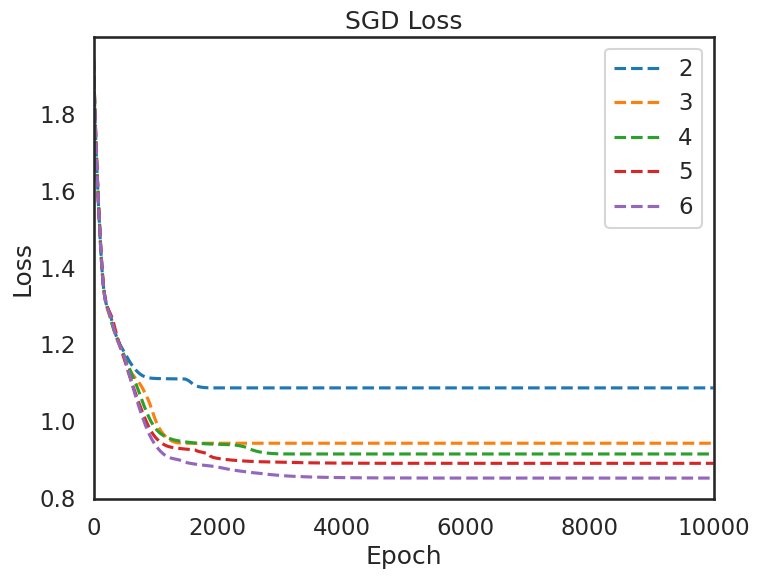

In [11]:
# SGD

plt.figure(figsize=(8, 6))

for x in all_lps:
    plt.plot(x, "--")
plt.legend(range(min_state, max_state))
# plt.ylim(-2, 2)
plt.xlim(0, 10000)
plt.title("SGD Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("sgd_loss.eps", format="eps")

In [12]:
# for x in all_lps:
#     plt.plot(x, "-")
# plt.legend(range(min_state, max_state))
# # plt.ylim(25000, 37000)
# plt.xlim(0, 200)

# plt.title("Expectation Maximization across states")
# plt.xlabel("Epoch")
# plt.ylabel("Log Likelihood")

In [13]:
def cross_validate(all_models, all_params, emissions, inputs):
    cross_valids = []

    for model_idx in range(len(all_models)):
        print(f'Cross Validating: {model_idx} model')
        state_log_probs = []
        for validation_idx in range(len(emissions)):
            log_prob = all_models[model_idx].marginal_log_prob(all_params[model_idx], emissions[validation_idx], inputs=inputs[validation_idx])
            state_log_probs.append(float(log_prob))
        cross_valids.append(state_log_probs)

    return np.array(cross_valids)

In [14]:
# cross_train = cross_validate(all_models, all_params, train_emissions, train_design)
cross_train = cross_validate(all_models, all_params, test_obs, test_design)


Cross Validating: 0 model
Cross Validating: 1 model
Cross Validating: 2 model
Cross Validating: 3 model
Cross Validating: 4 model


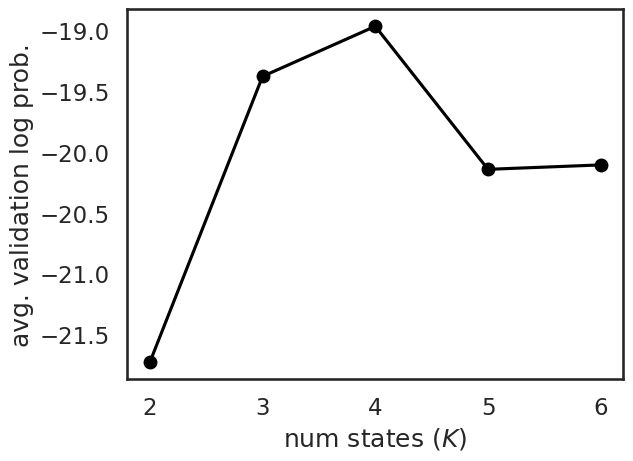

In [15]:
plot_validation(cross_valids=cross_train, show_var=False, max_states=max_state) 

In [16]:
cross_train

array([[-20.52076721, -21.95863724, -24.18773651, ..., -23.65502548,
        -14.78162479, -24.21635246],
       [-18.93778229, -22.94047546, -21.91452217, ..., -21.2899437 ,
         -5.92283916, -22.42247581],
       [-17.92542458, -23.77259445, -21.57754898, ..., -21.27910233,
         -7.03204775, -21.81765556],
       [-18.44799423, -22.04334068, -20.4379673 , ..., -23.28907204,
         -7.9331851 , -24.94410133],
       [-18.50622368, -30.30969048, -20.42036247, ..., -24.63670921,
         -7.69512367, -26.1313858 ]])

In [ ]:
np.save("cross_test.npy", cross_train)

/tmp/ipykernel_8471/2173894839.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(min_state, max_state))


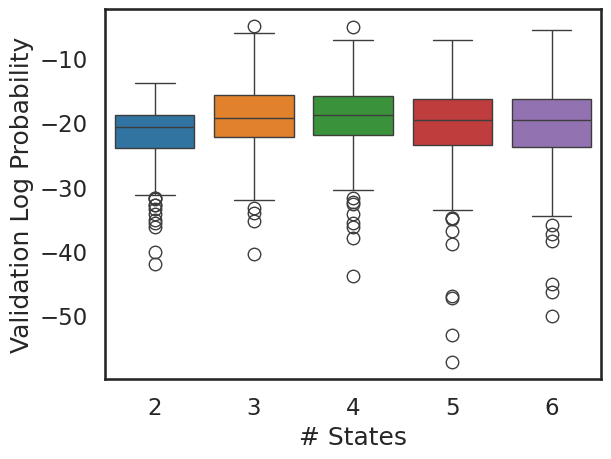

In [17]:
ax = sns.boxplot(data=cross_train.T)
ax.set_xticklabels(range(min_state, max_state))
plt.xlabel("# States")
plt.ylabel("Validation Log Probability")
plt.savefig("validation_box.eps", format="eps")

In [18]:
# np.save("../cache/cross_valid.npy", cross_train)

In [19]:
# temp = np.load("../cache/cross_valid.npy")
# temp.shape

In [20]:
# def inspect_sample(model_idx, em_idx):
#     most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
#     posterior = all_models[model_idx].smoother(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
#     plot_emissions_and_states(train_emissions[em_idx], most_likely_states, posterior, cmap, colors)

# for i in range(2):
#     inspect_sample(5-2, i)

In [21]:
# print("transitions", p_fourth.transitions.transition_matrix)
# print("weights", p_fourth.emissions.weights)
# print("biases", p_fourth.emissions.biases)
# print("covs", p_fourth.emissions.covs)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


| state 1 | covs 0.02764732390642166 |
--------------------------------------------------
| state 2 | covs 0.2634938359260559 |
--------------------------------------------------
| state 3 | covs 0.07200406491756439 |
--------------------------------------------------


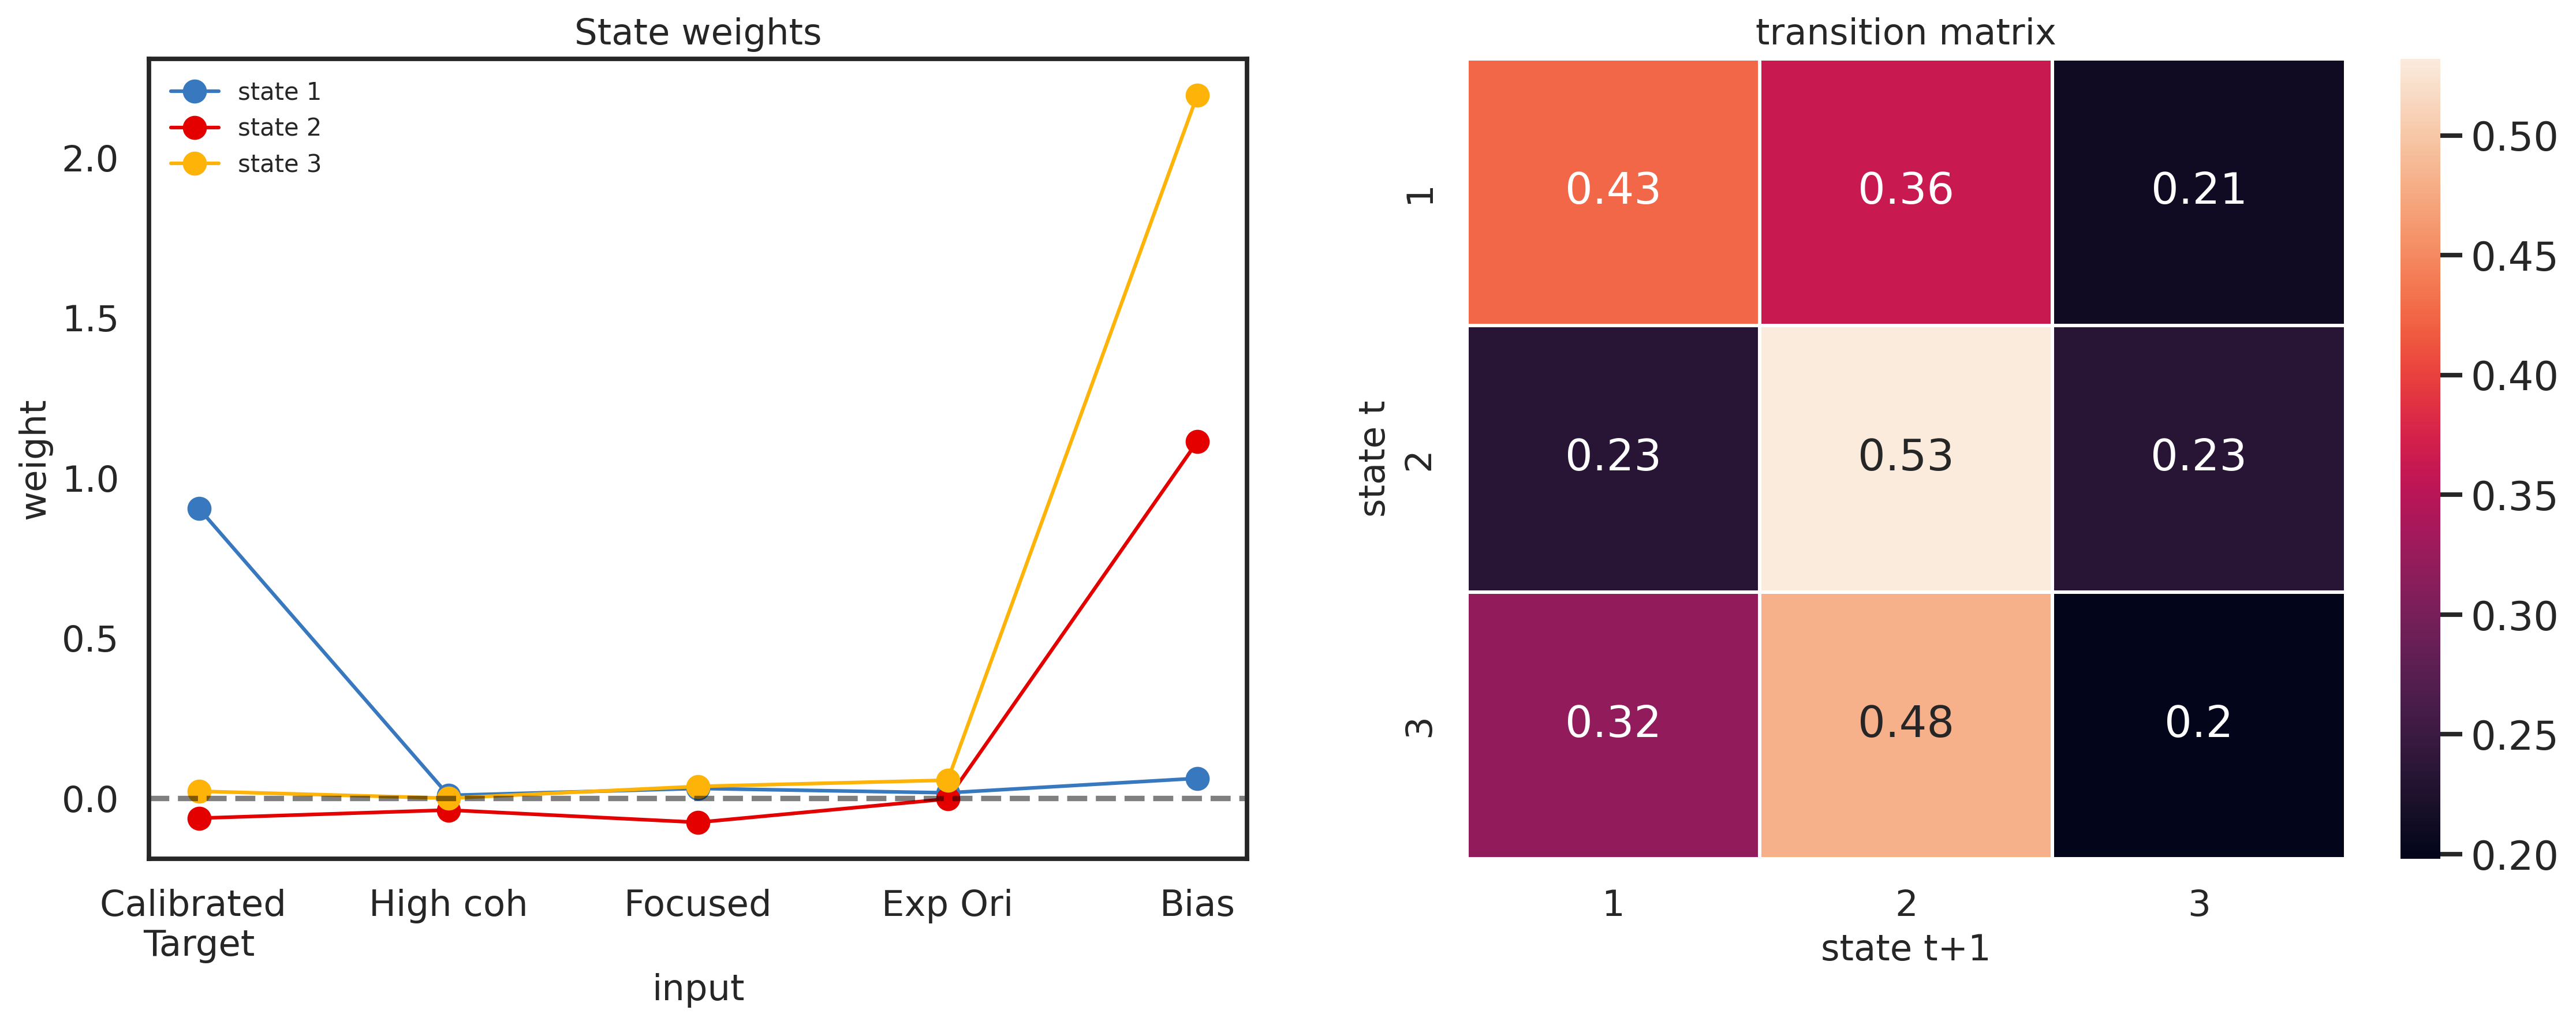

In [22]:
model_to_check = 3

fourth = all_models[model_to_check - 2]
p_fourth = all_params[model_to_check - 2]

curr_states = model_to_check

# Plot MLE parameters:
fig = plt.figure(figsize=(12*1.5, 4*1.5), dpi=300, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = colors
for k in range(curr_states):
    plt.plot(range(input_dim), p_fourth.emissions.weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))

# for k in range(curr_states):
#     plt.plot(range(input_dim), p_fourth.emissions.weights[k][0] + p_fourth.emissions.biases[k], marker='x',
#              color=cols[k], linestyle='--', alpha = 0.5,
#              lw=1.5, label=f"state {k+1} + bias")

plt.yticks(fontsize=15)
plt.ylabel("weight", fontsize=15)
plt.xlabel("input", fontsize=15)
# plt.xticks([0, 1, 2, 3], ['target', 'coherance', 'focus', 'bias (0)'], fontsize=10, rotation=45)
plt.xticks([0, 1, 2, 3, 4], ['Calibrated \nTarget', 'High coh', 'Focused', 'Exp Ori', "Bias"], fontsize=15, rotation=0)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
# transparant boundery for legend
plt.legend(framealpha = 0, fontsize=10)
plt.title("State weights", fontsize = 15)




plt.subplot(1, 2, 2)
gen_trans_mat = p_fourth.transitions.transition_matrix
sns.heatmap(gen_trans_mat, annot=True, linewidths=1, linecolor='white')
# put the ticks 
plt.xticks(np.arange(curr_states) + 0.5, np.arange(curr_states) + 1, fontsize=15)
plt.yticks(np.arange(curr_states) + 0.5, np.arange(curr_states) + 1, fontsize=15)
# set font size of heatmap annotations
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("transition matrix", fontsize = 15)

# bias = p_fourth.emissions.biases.reshape(-1).tolist()
covs = p_fourth.emissions.covs.reshape(-1).tolist()

for i in range(curr_states):
    print("| state", i+1, "| covs", covs[i], "|")
    # print("| state", i+1, "| bias", bias[i], "| covs", covs[i], "|")
    print("-"*50)

plt.savefig("state_weights.eps", format="eps")

In [23]:
p_fourth.emissions.weights

Array([[[ 9.0473872e-01,  8.9850621e-03,  3.0508356e-02,  1.6957700e-02,
          6.2123414e-02]],

       [[-6.2253434e-02, -3.6803599e-02, -7.5213976e-02, -2.1761821e-03,
          1.1134648e+00]],

       [[ 2.1868434e-02,  1.0877915e-04,  3.7032347e-02,  5.6398489e-02,
          2.1950879e+00]]], dtype=float32)

In [24]:
model_to_check, test_obs.shape

(3, (260, 20, 1))

In [25]:
model_idx = model_to_check-2
all_posteriors = []

for em_idx in range(train_emissions.shape[0]):
    most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    posterior = all_models[model_idx].smoother(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    all_posteriors.append(posterior.predicted_probs)

log_likelihoods.shape (20, 3)
(0.0, Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>)
Traced<ShapedArray(int32[20])>with<DynamicJaxprTrace(level=2/0)>


In [26]:
avg_sess = np.array(all_posteriors).mean(axis=0)
std_sess = np.array(all_posteriors).std(axis=0)

avg_sess.shape, std_sess.shape

((20, 3), (20, 3))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


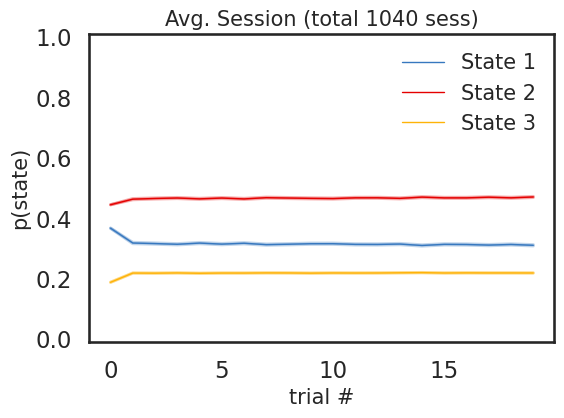

In [27]:
plt.figure(figsize=(6, 4))

K = model_to_check
total_sessions = train_emissions.shape[0]

for k in range(K):
    plt.plot(avg_sess[:, k], label="State " + str(k + 1), lw=1,
                color=cols[k])
    se = std_sess[:, k] / np.sqrt(total_sessions)
    plt.plot(avg_sess[:, k] + se, color=cols[k], alpha=0.3)
    plt.plot(avg_sess[:, k] - se, color=cols[k], alpha=0.3)

# plt.xticks([0, 45, 90], ["", "", ""], fontsize=15)
# plt.yticks([0, 0.5, 1], ["", "", ""], fontsize=15)
plt.ylim((-0.01, 1.01))
plt.title(f"Avg. Session (total {total_sessions} sess)", fontsize=15)
plt.xlabel("trial #", fontsize=15)
plt.ylabel("p(state)", fontsize=15)
plt.legend(fontsize=15, framealpha=0)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.xticks([0, 45, 90, 120], ["0", "45", "90", "120"], fontsize=15)
# plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], fontsize=15)

plt.savefig("avg_sess.eps", format="eps")

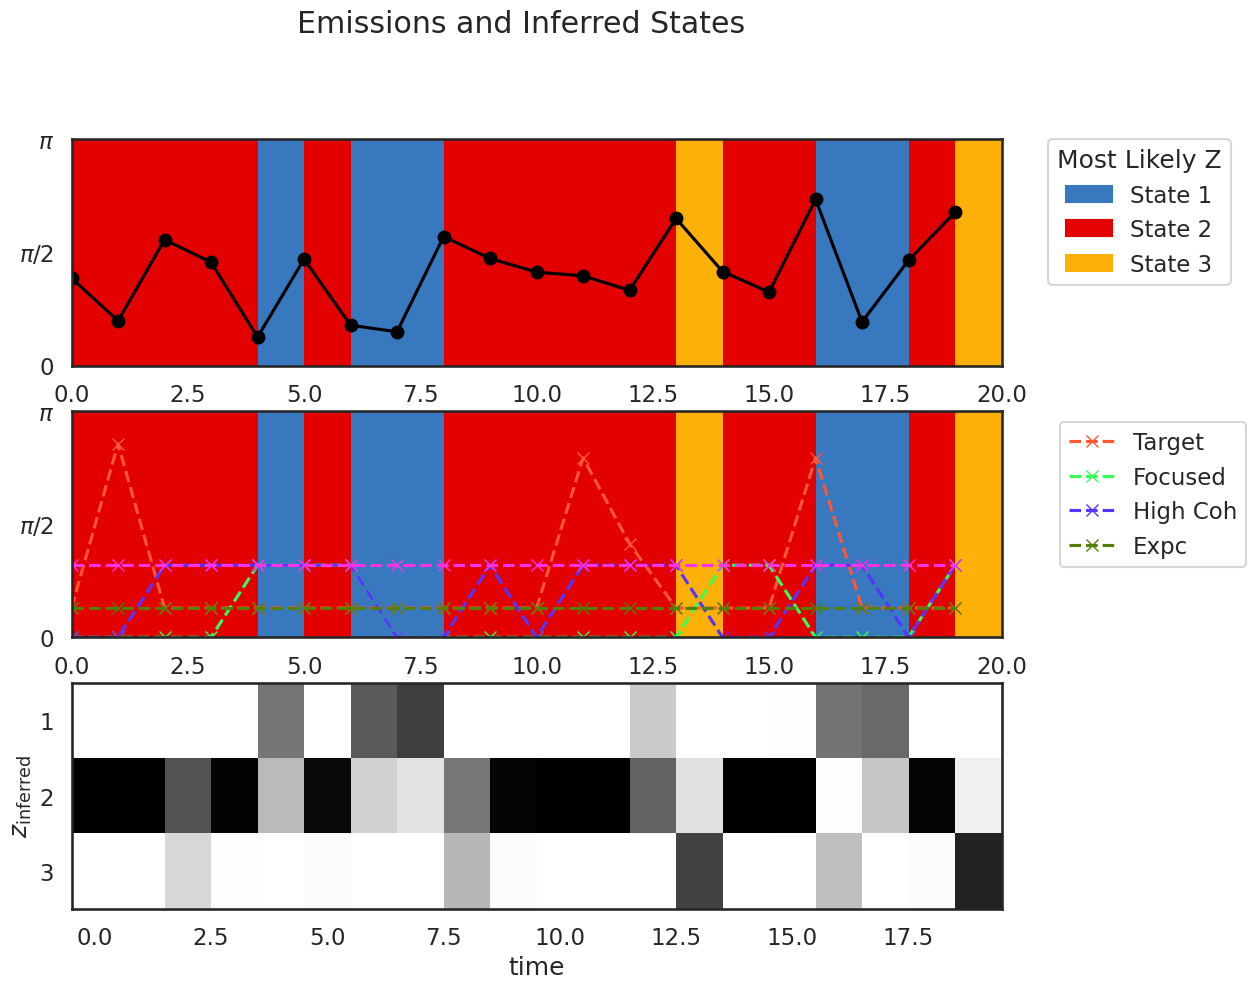

In [28]:
def inspect_sample(model_idx, em_idx):
    most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], test_obs[em_idx], inputs=test_design[em_idx])
    posterior = all_models[model_idx].smoother(all_params[model_idx], test_obs[em_idx], inputs=test_design[em_idx])
    plot_emissions_and_states(test_obs[em_idx], test_design[em_idx], most_likely_states, posterior, cmap, colors)

for i in range(1):
    inspect_sample(model_to_check-2, i)



In [29]:
from tensorflow_probability.substrates import jax as tfp
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions


In [30]:
wts = p_fourth.emissions.weights
cvs = p_fourth.emissions.covs

In [31]:
wts.shape, cvs.shape

((3, 1, 5), (3, 1, 1))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


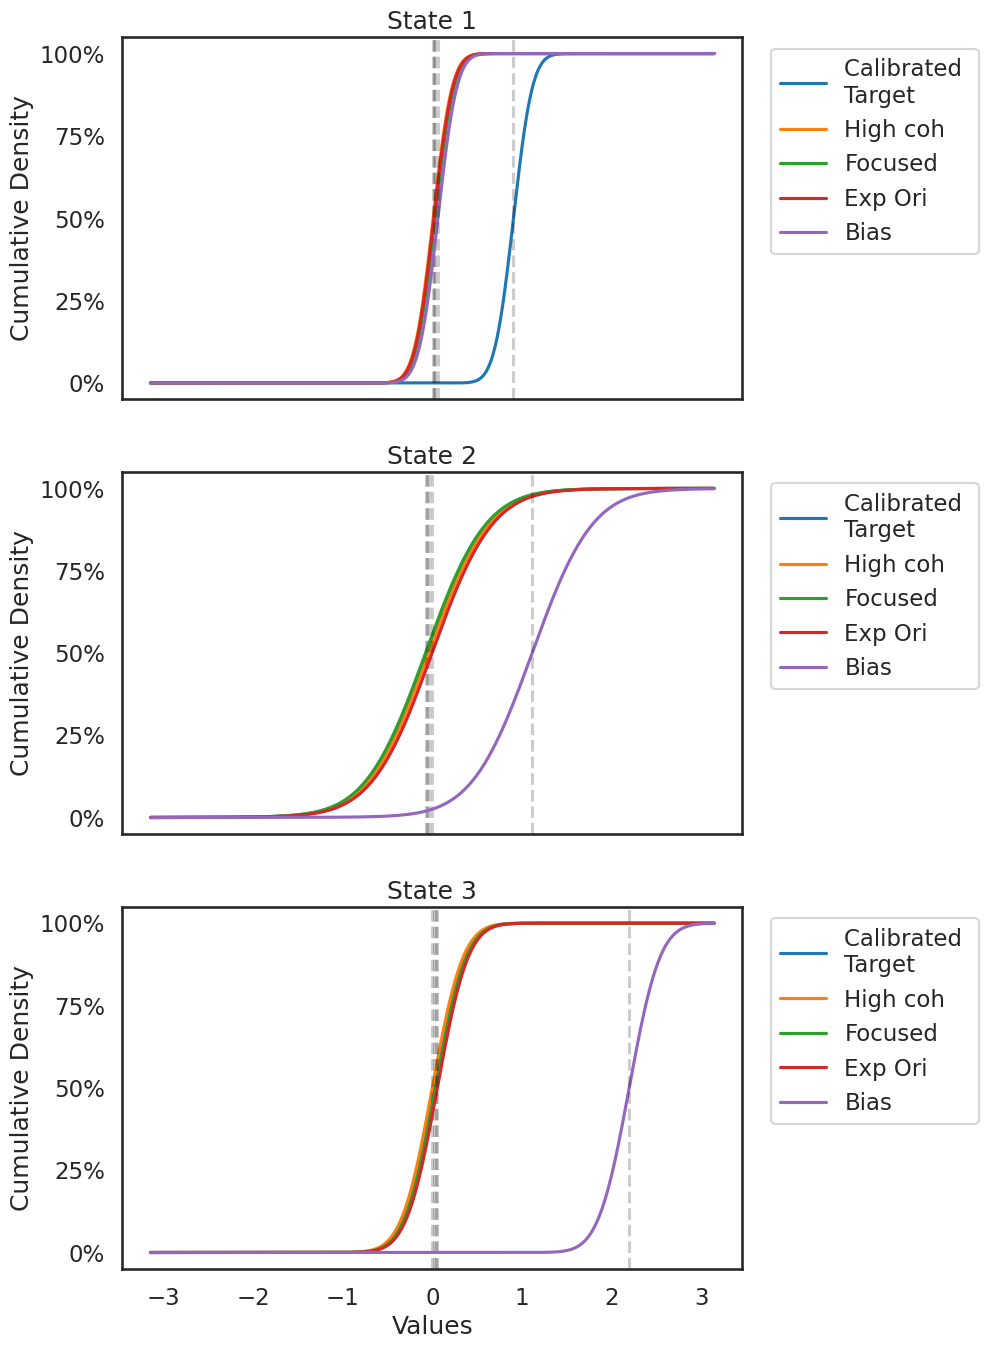

In [32]:
# make 3, 1 plot
designs = ['Calibrated \nTarget', 'High coh', 'Focused', 'Exp Ori', "Bias"]

fig, axs = plt.subplots(3, 1, figsize=(8, 16))

for i in range(3):
    ax = axs[i]

    curr_wt = wts[i][0]
    curr_vr = cvs[i]
    
    for idx, name in enumerate(designs):
    
        # ax.axvline(curr_wt[idx], color='k', linestyle='--', alpha=0.5)
        
        dst = tfd.VonMises(curr_wt[idx], 1/curr_vr[idx])
        x = np.linspace(-np.pi, np.pi, 1000)
        y = dst.cdf(x)


        ax.plot(x, y, label=name)

        # put mean in the plot and the y axis
        ax.axvline(curr_wt[idx], color='k', linestyle='--', alpha=0.2)

    ax.set_title(f"State {i+1}")
    ax.set_ylabel("Cumulative Density")

    # # give space between subplots
    # plt.subplots_adjust(hspace=0.5)

    # Only show ticks on the last plot
    if i == 2:
        ax.set_xlabel("Values")
    else:
        ax.set_xticks([])

    # combine all x axis to bottom
    # ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    # ax.set_xticklabels(["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
        
    ax.set_yticks([0, 0.25, 0.5,0.75, 1])
    ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])

    # put legend outside on the top right
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

plt.savefig("state_cdf.eps", format="eps")

In [33]:
curr_wt

Array([2.1868434e-02, 1.0877915e-04, 3.7032347e-02, 5.6398489e-02,
       2.1950879e+00], dtype=float32)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


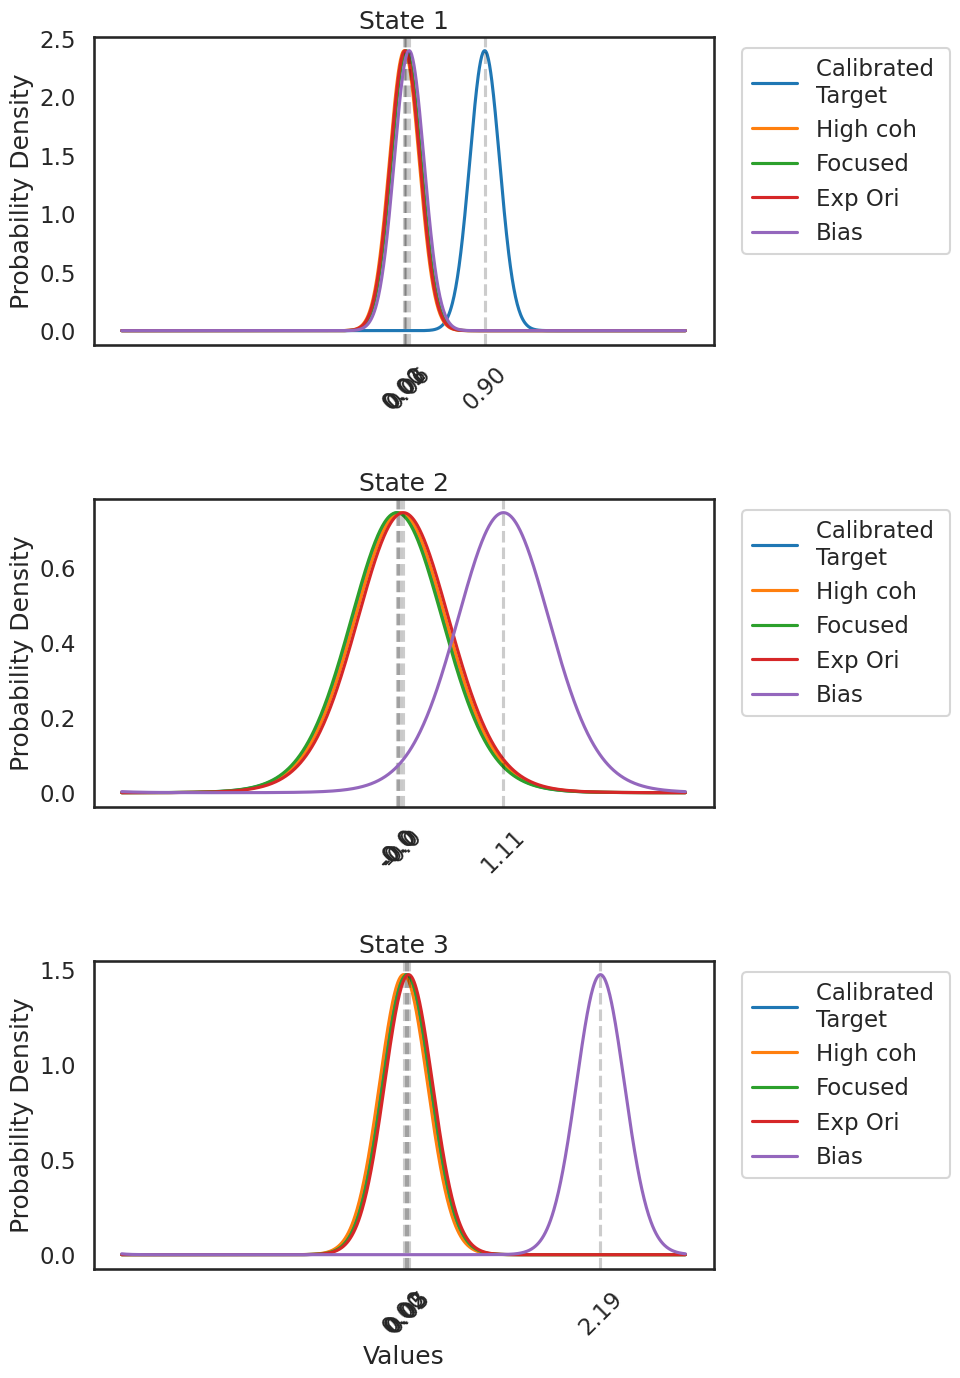

In [34]:
# Now do almost the same for pdf

fig, axs = plt.subplots(3, 1, figsize=(8, 16))

for i in range(3):
    ax = axs[i]

    curr_wt = wts[i][0]
    curr_vr = cvs[i]
    
    for idx, name in enumerate(designs):
    
        # ax.axvline(curr_wt[idx], color='k', linestyle='--', alpha=0.5)
        
        dst = tfd.VonMises(curr_wt[idx], 1/curr_vr[idx])
        x = np.linspace(-np.pi, np.pi, 1000)
        y = dst.prob(x)


        ax.plot(x, y, label=name)

        # put mean in the plot and the y axis
        ax.axvline(curr_wt[idx], color='k', linestyle='--', alpha=0.2)

    ax.set_title(f"State {i+1}")
    ax.set_ylabel("Probability Density")

    # give space between subplots
    plt.subplots_adjust(hspace=0.5)

    # Only show ticks on the last plot
    if i == 2:
        ax.set_xlabel("Values")
    # else:
    #     ax.set_xticks([])
        
    # mark the mean on x axis
    ax.set_xticks(curr_wt)
    ax.set_xticklabels([str(x)[:4] for x in curr_wt], rotation=45)


    # put legend outside on the top right
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

plt.savefig("state_pdf.eps", format="eps")

In [35]:
g = sns.displot(data=penguins, x="flipper_length_mm", y="bill_length_mm", kind="kde", rug=True)

NameError: name 'penguins' is not defined

In [ ]:
from tensorflow_probability.substrates import jax as tfp
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions

dst = tfd.VonMises(loc=0, concentration=1)

data = dst.sample(1000, seed=jr.PRNGKey(1))


# # plot the pdf
# x = np.linspace(-np.pi, np.pi, 100)
# plt.plot(x, dst.prob(x))

# # plot the cdf
# plt.plot(x, dst.cdf(x))

# check = 5 # radiance

# # plot this on the graph as probability of value 5
# plt.plot(np.linspace(np.pi, np.pi *2, 100), dst.prob(np.linspace(np.pi, np.pi *4, 100)), '--')

# plt.plot(np.linspace(np.pi, np.pi *2, 100), dst.cdf(np.linspace(np.pi, np.pi *4, 100)), '--')



Array([ 1.83994025e-01,  2.24827409e+00,  1.98450074e-01,  2.11148873e-01,
       -4.90626812e-01, -9.86143470e-01, -6.33203566e-01, -7.54334688e-01,
        1.03532040e+00,  2.20785022e+00, -2.13990211e-01,  2.71977019e+00,
       -6.19381666e-01, -2.21994758e+00, -2.62563086e+00, -8.50916684e-01,
        2.72551394e+00, -5.18263876e-01,  4.87158626e-01,  1.22070387e-01,
       -8.79536927e-01, -7.67715037e-01, -1.38912424e-01, -3.30054224e-01,
        1.77830923e+00,  9.12180960e-01,  7.68472791e-01,  1.14583619e-01,
       -2.18232512e+00,  2.94333172e+00, -3.34877908e-01,  1.23692608e+00,
        1.82113910e+00, -4.58063304e-01, -1.76757920e+00,  3.53908926e-01,
       -1.26647457e-01,  3.01239371e+00,  1.95078444e+00,  2.21464443e+00,
       -2.15480518e+00, -1.59094822e+00, -2.60907078e+00,  1.18482280e+00,
        1.68728042e+00, -1.39671862e+00, -2.72112954e-02,  7.73976445e-02,
        2.00330544e+00,  4.38631415e-01, -3.27352196e-01, -5.89197695e-01,
        1.17415798e+00, -